In [1]:
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fcsy import DataFrame
import umap
import math
import networkx as nx

plt.style.use('surfdrive/pipelines/flowpipe/lib/plotstyle.mplstyle')

In [2]:
# Read info data
ledger = pd.read_excel('surfdrive/pipelines/flowpipe/AML_NBM_ledger_TMOCK01.xlsx', index_col=0)
ids = list(ledger['id'])

In [3]:
# Read all .FCS files and embed cluster labels
dfs = []
for patient_id in ids:
    
    if 'NBM' in patient_id:
        print(patient_id)
        df = DataFrame.from_fcs(f'AML_NBM/patients/{patient_id}/{patient_id}_T0_P1_1_processed.fcs')
        NBM_labels = pd.read_csv(f'AML_NBM/patients/{patient_id}/{patient_id}_T0_P1_1_fSOM_NBM_events.csv', index_col=0)
        Dx_labels = pd.read_csv(f'AML_NBM/patients/{patient_id}/{patient_id}_T0_P1_1_fSOM_T0_events.csv', index_col=0)

        # Merge data
        df = pd.merge(df, NBM_labels)
        df = pd.merge(df, Dx_labels)
        df['patient_id'] = patient_id

        # Subsample
        df = df.sample(n=10000)
        dfs.append(df)

cluster_data = pd.concat(dfs, ignore_index=True)

MRD_NBM_001
MRD_NBM_002
MRD_NBM_003
MRD_NBM_004
MRD_NBM_006
MRD_NBM_012
MRD_NBM_013
MRD_NBM_014
MRD_NBM_015
MRD_NBM_016
MRD_NBM_017
MRD_NBM_018
MRD_NBM_020
MRD_NBM_022
MRD_NBM_023
MRD_NBM_025
MRD_NBM_026
MRD_NBM_027
MRD_NBM_030
MRD_NBM_031
MRD_NBM_033


# Calculate UMAP Embeddings

In [4]:
channels = ['FITC-A', 'PE-A', 'PerCP-A', 'PC7-A', 'APC-A', 'APC-H7-A', 
            'Horizon V450-A', 'Horizon V500-A']

In [5]:
reducer = umap.UMAP(n_jobs=1)
embedding = reducer.fit_transform(cluster_data[channels])
embedding = pd.DataFrame(embedding)
embedding = embedding.rename(columns={0: 'UMAP1',
                                      1: 'UMAP2'})
embedding.index = cluster_data.index
cluster_data = pd.concat([cluster_data, embedding], axis=1)

([], [])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Trebuchet MS


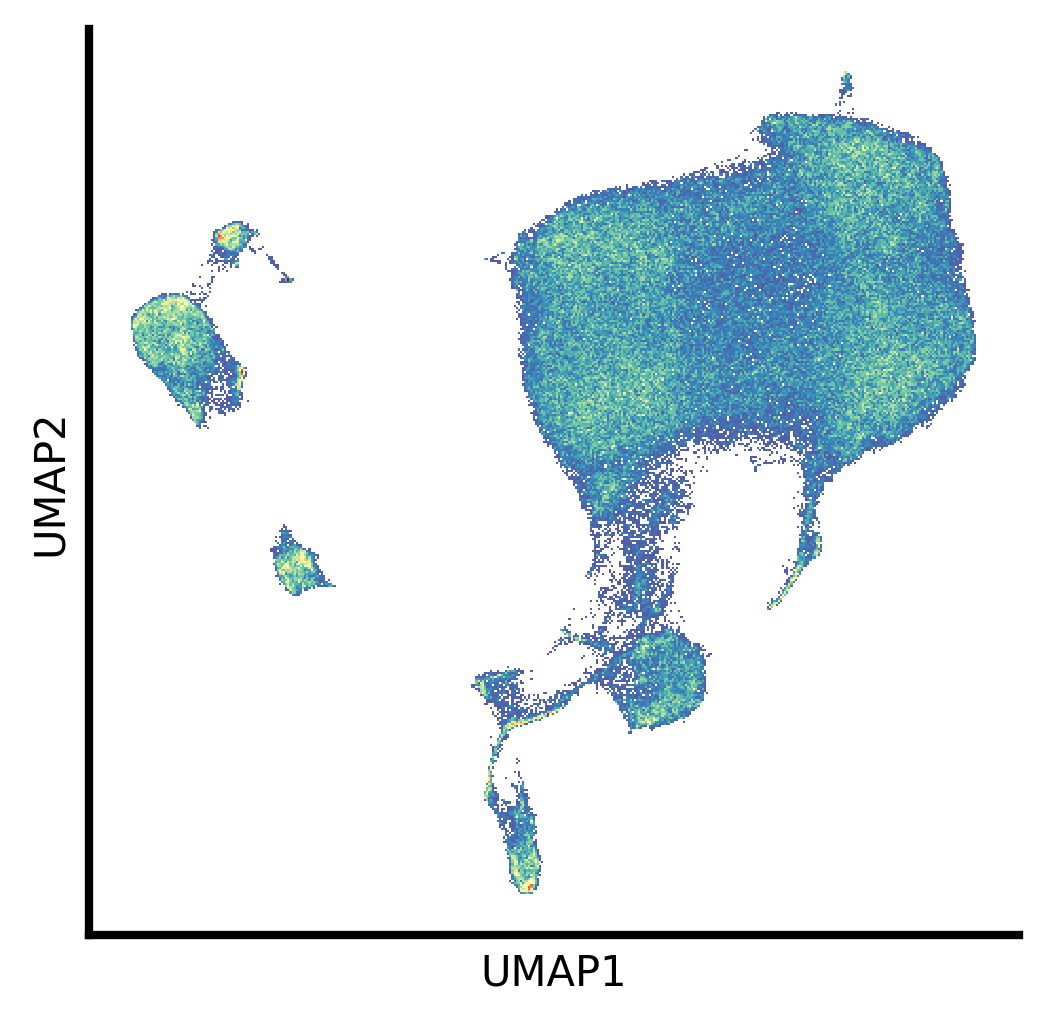

In [6]:
fig = plt.figure(figsize=(4, 4))

sns.histplot(data=cluster_data, x='UMAP1', y='UMAP2', cmap='Spectral_r', bins=400)
plt.xticks([], [])
plt.yticks([], [])

([], [])

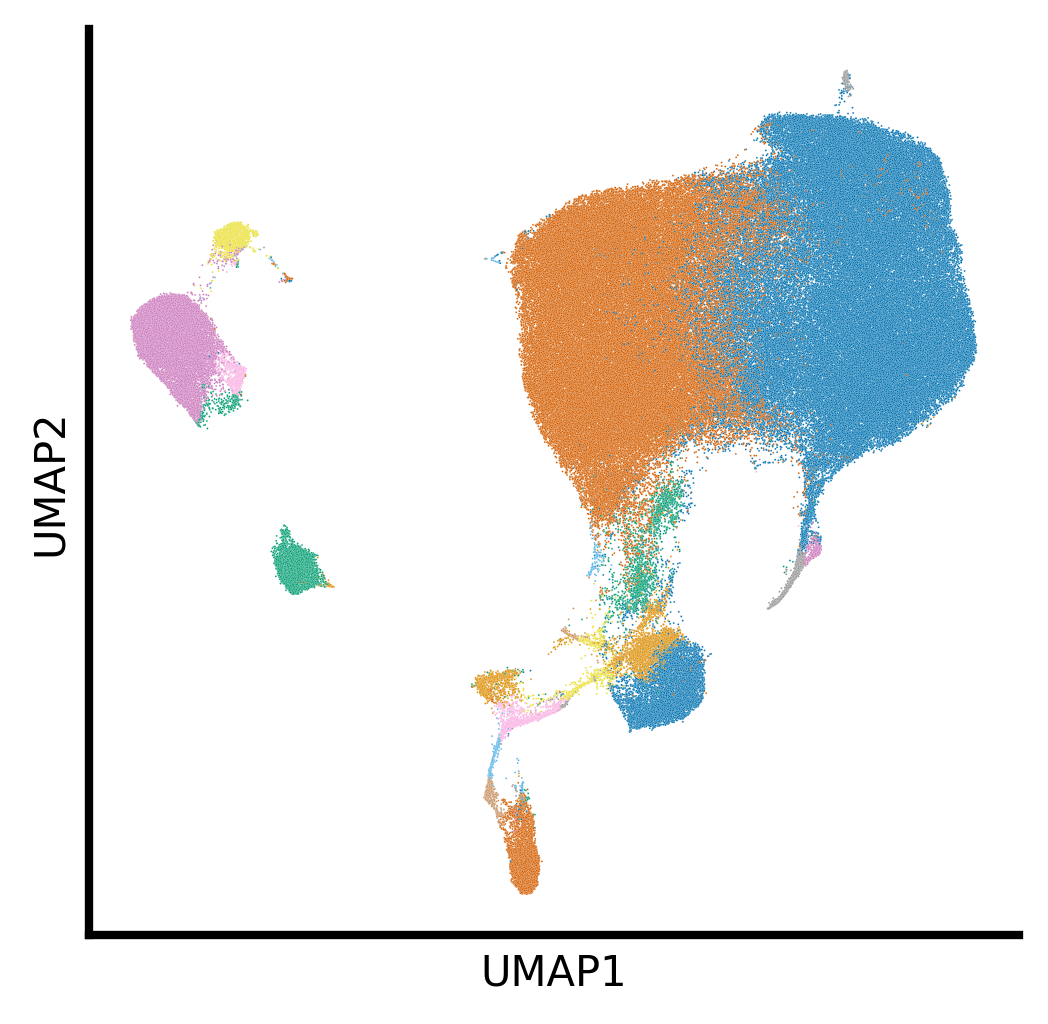

In [7]:
fig = plt.figure(figsize=(4, 4))

sns.scatterplot(data=cluster_data, x='UMAP1', y='UMAP2', palette='colorblind', hue='fSOM_NBM_metacluster', 
                s=0.2, legend=False)
plt.xticks([], [])
plt.yticks([], [])

# Calculate edges

In [8]:
NBM_dicts = []
for cluster1 in cluster_data['fSOM_NBM_metacluster'].unique():
    for cluster2 in cluster_data['fSOM_NBM_metacluster'].unique():
        if cluster1 != cluster2:
            NBM_dict = {}
            NBM_dict['source'] = 'NBM_'+str(cluster1)
            NBM_dict['target'] = 'NBM_'+str(cluster2)
            NBM_dict['type'] = 'NBM'
            
            X_a = cluster_data[cluster_data['fSOM_NBM_metacluster']==cluster1]['UMAP1'].median()
            X_b = cluster_data[cluster_data['fSOM_NBM_metacluster']==cluster2]['UMAP1'].median()

            Y_a = cluster_data[cluster_data['fSOM_NBM_metacluster']==cluster1]['UMAP2'].median()
            Y_b = cluster_data[cluster_data['fSOM_NBM_metacluster']==cluster2]['UMAP2'].median()

            eucl_dist = math.sqrt((X_a - X_b)**2 + (Y_a - Y_b)**2)
            NBM_dict['weight'] = eucl_dist
            NBM_dicts.append(NBM_dict)

In [9]:
Dx_dicts = []
for patient_id in cluster_data['patient_id'].unique():
    subset = cluster_data[cluster_data['patient_id']==patient_id]
    for cluster1 in subset['fSOM_T0_metacluster'].unique():
        for cluster2 in subset['fSOM_NBM_metacluster'].unique():
            Dx_dict = {}
            Dx_dict['source'] = 'Dx_'+str(patient_id)+'_'+str(cluster1)
            Dx_dict['target'] = 'NBM_'+str(cluster2)

            X_a = subset[subset['fSOM_T0_metacluster']==cluster1]['UMAP1'].median()
            X_b = subset[subset['fSOM_NBM_metacluster']==cluster2]['UMAP1'].median()

            Y_a = cluster_data[cluster_data['fSOM_T0_metacluster']==cluster1]['UMAP2'].median()
            Y_b = cluster_data[cluster_data['fSOM_NBM_metacluster']==cluster2]['UMAP2'].median()

            eucl_dist = math.sqrt((X_a - X_b)**2 + (Y_a - Y_b)**2)
            Dx_dict['weight'] = eucl_dist
            Dx_dicts.append(Dx_dict)

In [10]:
Dx_Dx_dicts = []

for patient1 in cluster_data['patient_id'].unique():
    subset1 = cluster_data[cluster_data['patient_id']==patient1]
    for patient2 in cluster_data['patient_id'].unique():
        if patient1 != patient2:
            subset2 = cluster_data[cluster_data['patient_id']==patient2]
            for cluster1 in subset1['fSOM_T0_metacluster'].unique():
                for cluster2 in subset2['fSOM_T0_metacluster'].unique():
                    Dx_dict = {}
                    Dx_dict['source'] = 'Dx_'+str(patient1)+'_'+str(cluster1)
                    Dx_dict['target'] = 'Dx_'+str(patient2)+'_'+str(cluster2)
                    
                    X_a = subset1[subset1['fSOM_T0_metacluster']==cluster1]['UMAP1'].median()
                    X_b = subset2[subset2['fSOM_T0_metacluster']==cluster2]['UMAP1'].median()
                    
                    Y_a = subset1[subset1['fSOM_T0_metacluster']==cluster1]['UMAP2'].median()
                    Y_b = subset2[subset2['fSOM_T0_metacluster']==cluster2]['UMAP2'].median()
                    
                    eucl_dist = math.sqrt((X_a - X_b)**2 + (Y_a - Y_b)**2)
                    Dx_dict['weight'] = eucl_dist
                    Dx_Dx_dicts.append(Dx_dict)

# Create & Draw network

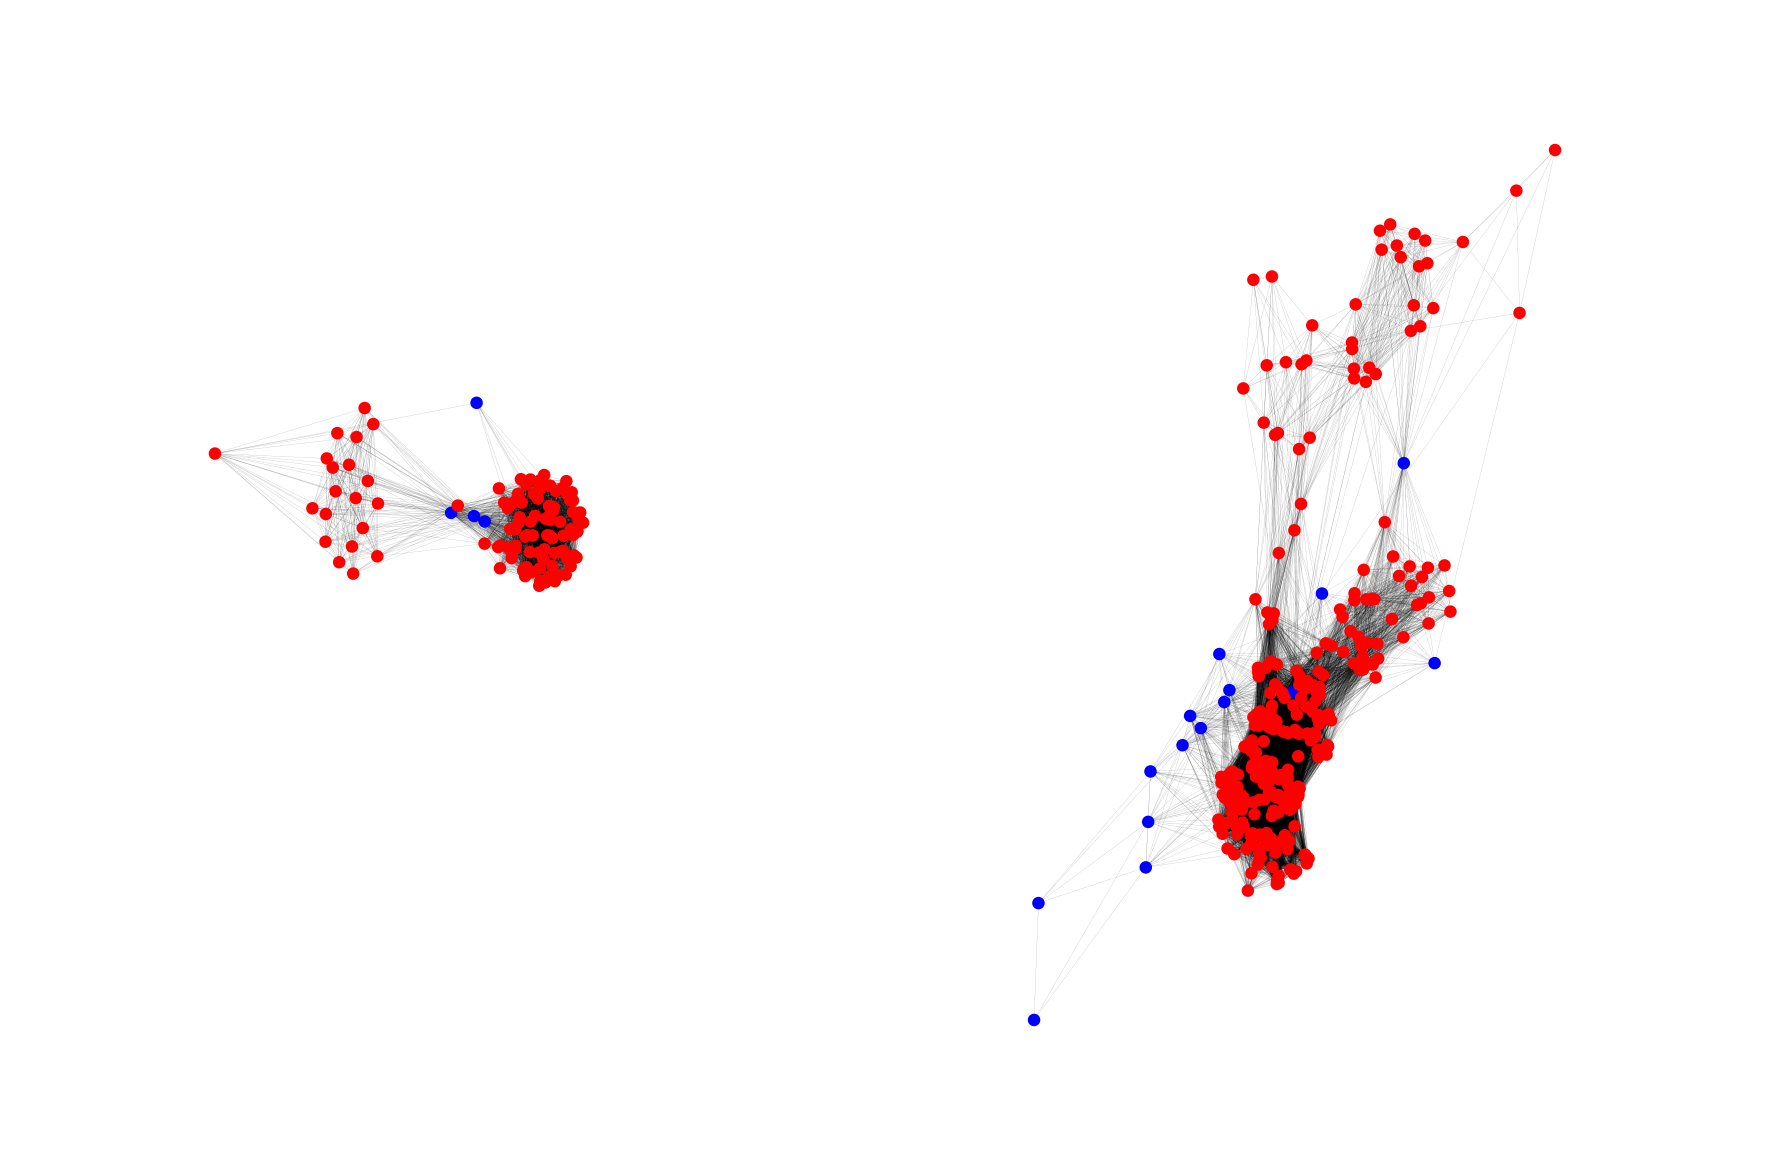

In [12]:
G = nx.Graph()

# for cluster in cluster_data['fSOM_NBM_metacluster']:
#     if 'NBM_'+str(cluster) not in G.nodes:
#         G.add_node('NBM_'+str(cluster))
        
for i in NBM_dicts:
    if i['weight'] < 4:
        G.add_edge(i['source'], i['target'], weight=i['weight'])

for i in Dx_dicts:
    if i['weight'] < 4:
#     if i['source'] not in G.nodes:
#         G.add_node(i['source'])
        G.add_edge(i['source'], i['target'], weight=i['weight'])
        
for i in Dx_Dx_dicts:
    if i['weight'] < 4:
        G.add_edge(i['source'], i['target'], weight=i['weight'])

pos = nx.spring_layout(G, seed=42)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 10]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 10]

# nodes
color_map = []
for node in G:
    if 'Dx' in node:
        color_map.append('red')
    else: 
        color_map.append('blue')    
    
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=4)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=0.05, alpha=0.5, edge_color="black", style="dashed")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=0.05, alpha=0.5, edge_color="black", style="dashed")

# labels
# nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()